# Feedforward Neural Network Classifier


This notebook demonstrates how feedforward neural networks can solve classification problems that single-layer perceptrons cannot. We will build and train a 2-layer neural network to classify data that is not linearly separable, using PyTorch to implement the model, training loop, and visualization of decision boundaries.

## Import libraries

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

## Generating Data

Here, we generate a dataset consisting of 3 classes in 2 dimensional space, where no two classes are linearly separable.

In [4]:
np.random.seed(352)
torch.manual_seed(0)

N = 100 # number of points per class
C = 3 # number of classes

def generate_data(N, num_class):
    X = np.zeros((2, N*num_class)) # data matrix
    y = np.zeros(N*num_class) # class abels

    for j in range(num_class):
        ix = range(N*j,N*(j+1))
        r = np.linspace(0.0, 1, N) # radius
        t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
        X[:,ix] = np.c_[r*np.sin(t), r*np.cos(t)].T
        y[ix] = j

    return X.T, y

# Generate data
data, labels = generate_data(N, C)

# # Uncomment to see the shape of data and labels
print("Data shape :", data.shape)
print("Labels shape :", labels.shape)


Data shape : (300, 2)
Labels shape : (300,)


At this point let's visualize the dataset we just generated.

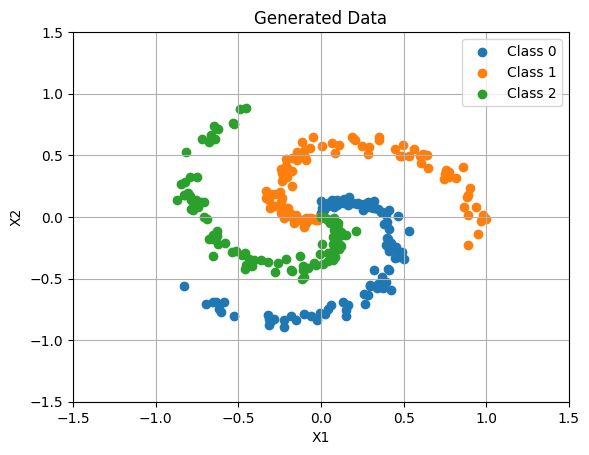

In [5]:
for i in range(C):
  plt.scatter(data[i*N:(i+1)*N, 0], data[i*N:(i+1)*N, 1], label=('Class ' + str(i)))

plt.xlim([-1.5, 1.5])
plt.ylim([-1.5, 1.5])
plt.title("Generated Data")
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend()
plt.grid(True)
plt.show()


## DataLoader Implementation


Complete the PointDataset by replacing ```NotImplemented``` with your code


In [6]:
class PointsDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.tensor(data, dtype=torch.float)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __getitem__(self, index):
        # Retrieve the point and label at the given index
        point = self.data[index]
        label = self.labels[index]
        return point, label

    def __len__(self):
        # Return the total number of samples in the dataset
        return len(self.data)

class PointsDataLoader(DataLoader):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.transform = lambda x: x  # No transformation by default

    def __iter__(self):
        for batch in super().__iter__():
            yield self.transform(batch)

## Building the Neural Network


<p align="center"> <img src="https://www.ritchievink.com/img/post-9-mlp/nn_diagram_1.png" alt="nn" style="width: 700px;"/> </p>


This implementation builds a model using the layers provided by PyTorch. For more details, refer to: [Building Models with PyTorch](https://pytorch.org/tutorials/beginner/introyt/modelsyt_tutorial.html). Our model will be described as consisting of the following components:

Linear Layer: $$\mathbf{Z}^{(2)} = \mathbf{W}^{(1)T}\mathbf{X} $$

ReLU Activation: $$\mathbf{A}^{(2)} = \max(\mathbf{Z}^{(2)}, \mathbf{0}) $$

Linear Layer:$$\mathbf{Z}^{(3)} = \mathbf{W}^{(2)T}\mathbf{A}^{(1)} $$

Softmax Activation:$$\mathbf{\hat{Y}} = \mathbf{A}^{(3)} = \text{softmax}(\mathbf{Z}^{(3)})$$


In [7]:
class FFNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim) -> None:
        super(FFNN, self).__init__()

        # Define the first linear layer
        self.fc1 = nn.Linear(input_dim, hidden_dim)

        # Define the second linear layer
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # First linear layer with ReLU activation
        z2 = self.fc1(x)
        a2 = F.relu(z2)

        # Second linear layer
        z3 = self.fc2(a2)

        # Softmax activation on the output
        y_hat = F.softmax(z3, dim=1)

        return y_hat


## Training the Model
